<a href="https://colab.research.google.com/github/KimJisanER/medical_ai/blob/main/%5Bopen%5D_01_ECG_arrhythmia_detection_using_MIMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 의료인공지능 전문가 양성과정 2022
## MIMIC waveform Tutorial : ECG arrhythmia detection
- Date : Sep. 03, 2022
- Author : **Hyun-Lim Yang, Ph.D.**<br>
Research Assistant Professor @
Seoul National University Hospital <br>
Department of Anesthesiology and Pain Medicine
- E-mail : hlyang{_at_}snu{_dot_}ac{_dot_}kr
***


## 0. Goal
#### Heart Arrhythmia Detection from ECG waveform with Deep  Learning model
본 강의에서는 **딥러닝을 이용해서 ECG waveform을 분석하고 arrhythmia를 예측하는 방법**을 알아봅니다.<br>
아래의 온라인 자료들을 활용하여 더 많은 정보를 확인할 수 있습니다.<br>
(본 강의도 아래 자료의 내용을 참고하였습니다.)<br>
>Reference source: <br>
> https://github.com/andrewwlong/deep_arrhythmias <br>
> https://towardsdatascience.com/detecting-heart-arrhythmias-with-deep-learning-in-keras-with-dense-cnn-and-lstm-add337d9e41f <br>
> https://github.com/eddymina/ECG_Classification_Pytorch/blob/master/ECG_notebook.ipynb <br>
***

## 1. Backgrounds
### 1-1. Dataset
**MIT-BIH Arrhythmia dataset**을 활용하여 실습을 진행합니다. <br>
(source: https://physionet.org/content/mitdb/1.0.0/) <br>
이 데이터셋은 Boston's Beth Israel Hospital 에서 1975년 ~ 1979년 사이 in-patient & out-patient를 모두 포함하는 4000명 환자의 case에서, **23개 case를 랜덤 샘플**하고 **중요한 arrhythmia를 포함하는 25개 case를 임의로 선택**하여 구축하였습니다.<br>
360Hz를 가지는 2-channel ECG waveform과 annotation을 포함합니다.

### 1-2. Deep Learning Framework 
본 실습에서는 **`Keras`**를 활용합니다. (official site: https://keras.io/ko/)<br>
`Keras`는 **high-level open source deep learning framework**로 Tensorflow, PyTorch, Caffe, MXNet 등과 함께 많이 쓰이는 프레임워크 입니다.<br>
특히 `Keras`는 개발 초기에는 독립된 high-level API 로써 `Tensorflow` 혹은 `Theano`를 backend로 하여 서비스를 제공하였으나, **최근 `Tensorflow 2.0`에 완전 통합**되어 `Tensorflow 2.0`을 통해 제공됩니다. High-level API의 특성상 개발의 자유도는 다소 떨어지나, 사용편의성이 매우 높아서 빠르게 결과물을 확인하고자 하는 인공지능 연구자들이나 산업계에서도 인기가 높습니다. 더욱이 초급자들이 딥러닝을 학습하기에 아주 좋은 framework 입니다.<br>
사용자 편의를 위한 다양한 함수들을 제공하고 확장성 또한 우수한 편입니다. 파이썬과 매우 호환이 잘 되고 [pythonic](https://www.python.org/dev/peps/pep-0020/) 한 코드를 제공합니다.

### 1-3. Other packages
이외에 사용되는 주요한 패키지는 다음과 같습니다:
1. `wfdb` : MIT-BIH arrhythmia dataset을 배포하는 MIMIC 팀이 자체 데이터를 처리하기 위해 개발하고 배포하는 패키지 입니다. signal과 annotation data를 읽어오는데 사용합니다.
2. `numpy` : 벡터, 행렬 연산에 특화된 패키지 입니다.
3. `pandas` : 데이터 분석에 특화된 패키지 입니다. 데이터 전처리와 후처리에 활용합니다.
4. `matplotlib` : Data visualization에 특화된 패키지 입니다. 각종 plotting에 활용합니다.
5. `sklearn` : 기계학습에 특화된 패키지 입니다. 모델 성능 분석에 활용합니다.


***

## 2. Data Downloads and Basic Statistics

In [1]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 4.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import os
import sys
import glob
import tqdm
import random
from itertools import cycle
import warnings
warnings.filterwarnings(action='ignore')

import wfdb

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.preprocessing import label_binarize

### 2.1 Data download
실습에 사용될 데이터를 다운받습니다.<br>
데이터 사이즈가 크지 않으므로 로컬로 mimic 홈페이지에서 바로 다운로드를 진행합니다<br>
> **Warning!** <br>
> 만약, 데이터 다운로드에 너무 오랜 시간이 걸리거나 오류가 있다면, 아래의 공유 링크를 클릭하여 '나의 드라이브에 바로가기 추가'를 하고, comment out한 코드를 실행시키세요. <br>
> Link: https://drive.google.com/drive/folders/1GJJXU5VFAG1nJVeYX-Yy3a2kbaYwuDq3?usp=sharing

In [3]:
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

download_directory = os.getcwd()
sys.path.append(download_directory)
os.listdir(download_directory)

--2022-09-03 01:15:32--  https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77030320 (73M) [application/zip]
Saving to: ‘mit-bih-arrhythmia-database-1.0.0.zip’

mit-bih-arrhythmia- 100%[===================>]  73.46M  2.63MB/s    in 29s     

2022-09-03 01:16:02 (2.51 MB/s) - ‘mit-bih-arrhythmia-database-1.0.0.zip’ saved [77030320/77030320]

Archive:  mit-bih-arrhythmia-database-1.0.0.zip
  inflating: mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mit-bih-

['.config',
 'mit-bih-arrhythmia-database-1.0.0',
 'mit-bih-arrhythmia-database-1.0.0.zip',
 'sample_data']

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# cloud_directory = '/content/gdrive/My Drive/mit_bih_arrhythmia/'
# download_directory = cloud_directory
# os.listdir(cloud_directory)

### 2-2. Data loading and basic statistics
데이터는 48개 케이스로 구성되고 각 케이스는 `hea`, `atr`, `dat`, `xws` 파일로 구성되어 있습니다.<br>
annotation 관련 정보는 `atr` 파일에 포함되어 있습니다.<br>
`wfdb` 패키지의 `rdann` 함수를 사용하여 `atr` 파일 내의 annotation을 불러올 수 있습니다.

In [5]:
# datapath
datapath = './mit-bih-arrhythmia-database-1.0.0/'
# mimic dataset 파일 구성: hea, atr, dat, xws
print(os.listdir(datapath))

['106.hea', '223.xws', '215.atr', '205.hea', '112.atr', '101.xws', 'SHA256SUMS.txt', '234.atr', '222.xws', '118.xws', '215.dat', '207.dat', '106.dat', '111.xws', '217.hea', '105.dat', '121.hea', '119.atr', '203.at-', '119.dat', '219.atr', '207.xws', '122.xws', '103.atr', '107.hea', '231.xws', '112.dat', '104.atr', '102.hea', '233.dat', '115.atr', '214.at_', '113.xws', '112.xws', '116.hea', '122.dat', '221.hea', '203.hea', '208.hea', '228.atr', '200.dat', '102.atr', '117.at_', '104.xws', '221.xws', '208.dat', '203.at_', '116.xws', '232.dat', '232.xws', '201.hea', '223.atr', '200.hea', '223.hea', '103.dat', '233.hea', '115.xws', '100.xws', '203.atr', '233.atr', '202.atr', '208.xws', '116.atr', '234.xws', '123.atr', '219.dat', '219.hea', '209.dat', '212.xws', '215.at_', '230.atr', '122.hea', '117.atr', '121.dat', '105.xws', '210.xws', '118.atr', '217.dat', '217.xws', '212.atr', '124.xws', '108.dat', '200.atr', '233.xws', '119.xws', '223.dat', '115.hea', '222.atr', '100.atr', '202.hea', '1

데이터에서 환자번호를 뽑아옵니다.

In [6]:
header_files = [os.path.basename(x) for x in glob.glob(os.path.join(datapath, '*.hea'))]
pids = sorted([x.split('.')[0] for x in header_files])

basename() : 확장자 빼고 이름만 불러옴.

In [7]:
# annotation 파일 불러와서 label의 분포 확인
df = pd.DataFrame()

for pid in pids:
    file = os.path.join(datapath, pid)
    annotation = wfdb.rdann(os.path.join(file), 'atr')
    symbols = annotation.symbol
    
    values, cnts = np.unique(symbols, return_counts=True)
    df_sub = pd.DataFrame({'symbol': values, 'value': cnts, 'pid':[pid] * len(cnts)})
    df = pd.concat([df, df_sub], axis=0)

In [36]:
df

,symbol,value,pid,type
0,+,1,100,-1
1,A,33,100,1
2,N,2239,100,0
3,V,1,100,1
0,+,1,101,-1
...,...,...,...,...
0,+,3,234,-1
1,J,50,234,1
2,N,2700,234,0
3,V,3,234,1


대부분의 annotation은 `N` symbol, 즉 정상 beat annotation을 가지고 있습니다.

In [8]:
# Annotation 파일의 분포
df.groupby('symbol').value.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: value, dtype: int64

MIT-BIH arrhythmia dataset에 포함되는 모든 annotation은 다음과 같습니다.<br>
보다 자세한 내용은 아래 공식 홈페이지에서 확인할 수 있습니다.<br>

> reference: <br> 
> https://www.physionet.org/physiobank/database/html/mitdbdir/tables.htm

Beat annotations:<br>

|Code	|	Description    |
| :-: | :- |
| N	|	Normal beat <br>(displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)|
|L	|	Left bundle branch block beat |
|R	|	Right bundle branch block beat |
|B	|	Bundle branch block beat (unspecified) |
|A	|	Atrial premature beat |
|a	|	Aberrated atrial premature beat |
|J	|	Nodal (junctional) premature beat |
|S	|	Supraventricular premature or ectopic beat (atrial or nodal) |
|V	|	Premature ventricular contraction |
|r	|	R-on-T premature ventricular contraction |
|F	|	Fusion of ventricular and normal beat |
|e	|	Atrial escape beat |
|j	|	Nodal (junctional) escape beat |
|n	|	Supraventricular escape beat (atrial or nodal) |
|E	|	Ventricular escape beat |
|/	|	Paced beat |
|f	|	Fusion of paced and normal beat |
|Q	|	Unclassifiable beat |
|?	|	Beat not classified during learning |

Non-beat annotations:<br>

|Code	|	Description|
| :-: | :- |
|\[	|	Start of ventricular flutter/fibrillation |
|!	|	Ventricular flutter wave |
|\]	|	End of ventricular flutter/fibrillation |
|x	|	Non-conducted P-wave (blocked APC) |
|(	|	Waveform onset |
|)	|	Waveform end |
|p	|	Peak of P-wave |
|t	|	Peak of T-wave |
|u	|	Peak of U-wave |
|\`	|	PQ junction |
|'	|	J-point |
|^	|	(Non-captured) pacemaker artifact |
||	|	Isolated QRS-like artifact |
|~	|	Change in signal quality |
|+	|	Rhythm change |
|s	|	ST segment change |
|T	|	T-wave change |
|*	|	Systole |
|D	|	Diastole |
|=	|	Measurement annotation |
|"	|	Comment annotation |
|@	|	Link to external data |



본 강좌에서는 non-beat annotation은 모두 무시하고, 정상과 비정상 beat만 구분하여 arrhythmia를 detect 할 수 있는 딥러닝 모델을 만들어 보겠습니다.

In [9]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [10]:
# normal, abnormal, nonbeat의 비율 구성 확인
df['type'] = -1 # nonbeat
df.loc[df.symbol == 'N', 'type'] = 0 # normal
df.loc[df.symbol.isin(abnormal), 'type'] = 1 # abnormal

In [11]:
df.groupby('type').value.sum()

type
-1     3186
 0    75052
 1    34409
Name: value, dtype: int64

#### Define ECG data loading function
`wfdb` 패키지를 이용하여 ECG waveform과 annotation을 불러올 수 있는 함수를 정의합니다.<br>
`rdrecord` 함수를 이용하여 raw signal 데이터를 불러옵니다 <br>
`rdann` 함수를 이용하여 annotation 데이터의 symbol 과 symbol의 index를 불러옵니다.

In [40]:
# load single patient's ecg signal and annotation
def load_ecg(file):
    """
    wfdb.rdrecord 를 이용해서 ecg 파일을 읽어옵니다.
    """
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_index = annotation.sample #annotaion의 포지션
    
    return p_signal, atr_sym, atr_index

예시로 신호 데이터의 일부를 plotting 해보면 다음과 같습니다.<br>
여기서, 각 변수는 다음을 의미합니다. <br>
`p_signal` = raw ecg signal <br>
`atr_sym` = annotation symbol <br>
`atr_sample` = annotation index <br>

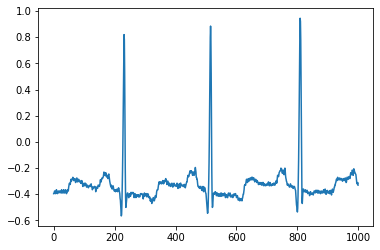

In [13]:
file = os.path.join(datapath, pids[0])
p_signal, atr_sym, atr_sample = load_ecg(file)
plt.plot(p_signal[1000:2000, 0])

이 환자 케이스에서 가지고 있는 annotation을 살펴보면 다음과 같습니다.

In [14]:
values, counts = np.unique(atr_sym, return_counts = True)
for v, c in zip(values, counts):
    print(v, c)

+ 1
A 33
N 2239
V 1


이 중 abnormal에 해당되는 annotation의 위치를 살펴보면 다음과 같습니다.

In [15]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

위의 abnormal에 해당되는 annotation의 index를 기준으로, 전후 3초의 ecg signal을 plotting 해보면 다음과 같습니다. 

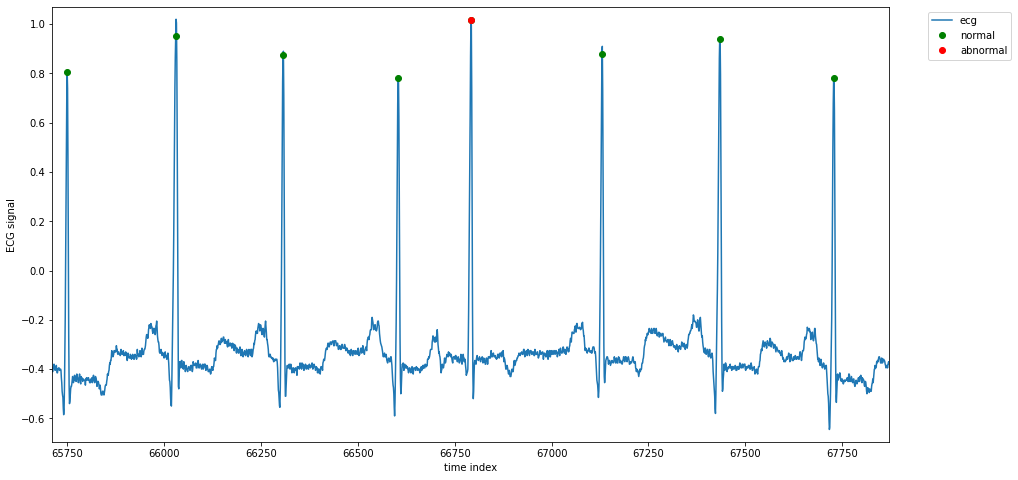

In [16]:
x = np.arange(len(p_signal))
left = ab_index[1]-(360*3) # 전 3초
right = ab_index[1]+(360*3) # 후 3초

plt.figure(figsize=(15, 8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

***

## 3. Preparing dataset for deep learning

### 3-1. Define functions to build dataset for deep learning
이제 본격적으로 딥러닝에 사용할 데이터셋을 구축 해보겠습니다.<br>
데이터셋 구축 방법은 딥러닝 모델의 구조와 추후 모델 활용 방식에 따라 여러가지가 있을 수 있습니다.<br>
본 강의에서는 `n`초의 raw signal waveform내에 arrhythmia를 포함하는지 아닌지를 detect 할 수 있는 딥러닝 모델을 만들어 보겠습니다.<br>
annotation 된 index를 기준으로, 전 후 `n/2`초의 raw signal을 하나의 segment로 자르고 그에 상응하는 annotation symbol을 label로 지정하여 데이터셋을 구축하겠습니다.<br>
<br>
우선 non-beat annotation을 제외하고 normal symbol과 abnormal symbol의 index만 추출합니다.<br>
추출된 annotation index를 기준으로 순회하며 abnormal symbol인 경우는 `Y` 값에 `1`을 할당하고, normal beat는 `0`을 할당합니다.<br>
또한 대응되는 annotation symbol을 별도로 추출하여 `symbol`값에 할당합니다.

In [17]:
def build_dataset(pids, window_size, freq, abnormal):
    """
    딥러닝 모델 학습을 위한 데이터를 구축합니다.
    """
    ncols = window_size * freq
    X_merged = np.zeros((1, ncols))
    Y_merged = np.zeros((1,1))
    symbol_merged = []
    
    rows_per_pid = []
    
    for pid in tqdm.tqdm(pids):
        
        filename = datapath + pid
        p_signal, atr_sym, atr_sample = load_ecg(filename)
        
        p_signal = p_signal[:,0]
        
        # beat index (exclude non-beat)
        beat_annotation_index = [x in (abnormal + ['N']) for x in atr_sym]
        
        X, Y, symbols = build_XY(signal=p_signal, 
                                 atr_sym = atr_sym, 
                                 atr_sample = atr_sample,
                                 beat_index = beat_annotation_index, 
                                 nsec = window_size/2, 
                                 fs = freq,
                                 ncols = ncols,
                                 abnormal = abnormal)
        
        X_merged = np.append(X_merged, X, axis=0)
        Y_merged = np.append(Y_merged, Y, axis=0)
        symbol_merged = symbol_merged + symbols
        rows_per_pid.append(Y.shape[0])
        
    # drop first zero rows
    X_merged = X_merged[1:,:]
    Y_merged = Y_merged[1:,:]
    
    # check sizes make sense
    assert np.sum(rows_per_pid) == X_merged.shape[0], 'number of X, max_rows rows messed up'
    assert Y_merged.shape[0] == X_merged.shape[0], 'number of X, Y rows messed up'
    assert Y_merged.shape[0] == len(symbol_merged), 'number of Y, sym rows messed up'
    
    return X_merged, Y_merged, symbol_merged


def build_XY(signal, atr_sym, atr_sample, beat_index, nsec, fs, ncols, abnormal):
    """
    하나의 환자 id에서 signal과 annotation을 추출합니다.
    """
    
    num_rows = len(beat_index)

    X = np.zeros((num_rows, ncols))
    Y = np.zeros((num_rows,1))
    symbols = []
    
    # keep track of rows
    max_row = 0
    
    beat_atr_sym = np.array(atr_sym)[beat_index]
    beat_atr_sample = np.array(atr_sample)[beat_index]

    for sym, samp in zip(beat_atr_sym, beat_atr_sample):

        left = int(max([0,(samp - nsec*fs) ]))
        right = int(min([len(signal),(samp + nsec*fs) ]))
        
        x = signal[left: right]
        if len(x) == ncols:
            X[max_row,:] = x
            Y[max_row,:] = int(sym in abnormal) #1,0으로 변환(T,F)
            symbols.append(sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X, Y, symbols

### 3-2. Build train and validation dataset
train과 validation에 사용할 데이터셋을 각각 구축합니다.<br>
일반적인 딥러닝 학습시에는 다음과 같이 데이터를 구축합니다.<br>
1. `train dataset`
2. `validation dataset`
3. `test dataset`

`train dataset`은 딥러닝 모델 학습에 사용되고, <br>
`validation dataset`은 딥러닝 학습 시 overfitting 등을 검증하는데 활용되고,<br>
`test dataset`은 딥러닝 모델 평가에 활용됩니다.<br>
<br>
본 강의에서는 편의상 `train dataset` 과 `validation dataset` 만 구축하여 모델을 학습하고 그 과정을 확인해보겠습니다. <br>
<br>
<font color='darkred'>여기서 주의할점은</font>, **case 기준으로 train과 validation을 구분해야 한다는 것**입니다.<br>
case를 구분하지 않고 전체 sample에서 random하게 train/validation을 구분할 경우 딥러닝 모델의 성능은 우수한 것으로 나올 수 있지만 실제 성능은 (training data이외의 데이터에서 평가시) 성능이 떨어지는 경우가 발생할 수 있습니다.<br>


In [41]:
# 6초의 segment로 데이터 구축
window_size = 6
frequency = 360
batch_size = 1000

In [42]:
# dataset split
random.seed(77)
pids_test = random.sample(pids, int(len(pids) / 4))
pids_train = [pid for pid in pids if pid not in pids_test]

In [43]:
# build dataset
X_train, Y_train, symbol_train = build_dataset(pids_train, 
                                               window_size, 
                                               frequency, 
                                               abnormal)
X_test, Y_test, symbol_test = build_dataset(pids_test,
                                              window_size,
                                              frequency,
                                              abnormal)

print("Shape of train dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_train.shape, Y_train.shape, len(symbol_train)))
print("Shape of test dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_test.shape, Y_test.shape, len(symbol_test)))

100%|██████████| 12/12 [00:01<00:00,  7.10it/s]

Shape of train dataset: 
 X: (82168, 2160) 
 Y: (82168, 1) 
 symbol: 82168 

Shape of test dataset: 
 X: (26931, 2160) 
 Y: (26931, 1) 
 symbol: 26931 



In [44]:
# train / test set symbol 확인
print(np.unique(symbol_train))
print(np.unique(symbol_test))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'R' 'S' 'V' 'a' 'e' 'f' 'j']
['/' 'A' 'F' 'L' 'N' 'R' 'V' 'a' 'j']


In [45]:
# train과 test set의 abnormal 비율 확인
print('{:.3f} %'.format((Y_train.sum() / len(Y_train))* 100))
print('{:.3f} %'.format((Y_test.sum() / len(Y_test))* 100))

30.569 %
34.109 %


***

## 4. Deep Learning model training - binary classification

첫번째 예제로 binary classification (이진분류) 을 수행해 보겠습니다.<br>
아주 단순한 Artificial Neural Network 모델을 사용할 것입니다.<br>
딥러닝 모델의 예측 결과가 0인 경우 normal beat 에 해당되고 1인 경우 abnormal에 해당합니다.

In [23]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

### 4-1. Define Fully Connected Network
아주 간단한 딥러닝 모델을 정의합니다.<br>
우선 다른 모듈을 사용하지 않고 단순한 linear layer 2개층을 가지는 네트워크를 생성해보겠습니다.<br>
모델의 input은 2160 sized raw waveform (360\*6=2160)이고 중간에 512개와 128개의 neuron을 갖는 layer를 하나 가지고 있는 단순한 네트워크 입니다.<br>
이진 분류를 위해서 모델 output에 `sigmoid` 함수를 취합니다.<br>
`Keras`에서는 모델을 선언 후 컴파일해주어야 합니다. 이때 loss function과 optimizer 등을 정의합니다.

In [24]:
fcn_model = Sequential()
fcn_model.add(Dense(512, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(128, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(1, activation='sigmoid'))

adam_optimizer = tf.keras.optimizers.Adam(lr=0.00005)
fcn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [51]:
fcn_model=Sequential()
fcn_model.add(Dense(512,activation='relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(256,activation='relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(128,activation='relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(1,activation='sigmoid'))

adam_optimizer=tf.keras.optimizers.Adam(lr=0.00005)
fcn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

### 4-2. Model fitting
모델을 학습시킵니다.<br>
학습 결과를 `train_history`에 저장하고 학습 과정동안의 loss 변화와 accuracy 변화를 확인합니다.<br>
Training 데이터의 일부 (여기서는 20%) 를 validation을 위해 사용합니다.

In [52]:
fcn_train_history = fcn_model.fit(X_train, Y_train, epochs=10, batch_size = batch_size, verbose=1,
                         validation_split = 0.2)

Epoch 1/10
66/66 [==============================] - 1s 12ms/step - loss: 0.5876 - accuracy: 0.7093 - val_loss: 0.3922 - val_accuracy: 0.8713
Epoch 2/10
66/66 [==============================] - 0s 7ms/step - loss: 0.4280 - accuracy: 0.8191 - val_loss: 0.3335 - val_accuracy: 0.8734
Epoch 3/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3412 - accuracy: 0.8664 - val_loss: 0.3062 - val_accuracy: 0.8799
Epoch 4/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2870 - accuracy: 0.8906 - val_loss: 0.2704 - val_accuracy: 0.8998
Epoch 5/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2423 - accuracy: 0.9106 - val_loss: 0.2531 - val_accuracy: 0.9067
Epoch 6/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2033 - accuracy: 0.9274 - val_loss: 0.2372 - val_accuracy: 0.9165
Epoch 7/10
66/66 [==============================] - 0s 7ms/step - loss: 0.1734 - accuracy: 0.9406 - val_loss: 0.2378 - val_accuracy: 0.9222
Epoch 8/10
66/66 [=

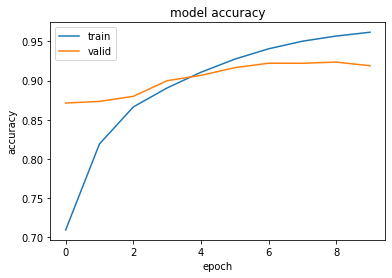

In [53]:
plt.plot(fcn_train_history.history['accuracy'])
plt.plot(fcn_train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

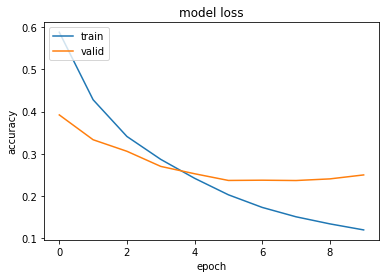

In [54]:
plt.plot(fcn_train_history.history['loss'])
plt.plot(fcn_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### 4-4. Result
학습완료된 모델을 바탕으로 test set 예측을 통해서 성능을 확인합니다.

In [59]:
fcn_prob = fcn_model.predict(X_test)
fcn_result = fcn_prob.argmax(axis=-1)

In [60]:
fcn_prob

array([[0.05035313],
       [0.21053708],
       [0.25230852],
       ...,
       [0.00281567],
       [0.00354234],
       [0.00245973]], dtype=float32)

모델의 성능은 다음의 metric들로 확인할 수 있습니다.<br>
의료 도메인에서는 **class imbalance가 매우 흔한 문제**입니다. (예를 들어 이 예제에서는 abnormal 비율이 적습니다.)<br>
이러한 환경에서 보다 정확한 모델 평가를 위해서 다음과 같이 **여러 metric을 함께 확인**하는 것이 좋습니다.

precision = 모델이 True로 분류한 것 중 실제 True인 비율

$$ precision = {True\_positive \over True\_positive + False\_positive} $$

recall = 실제 Ture인 것 중에서 모델이 모델이 True라고 예측한 것의 비율

$$ recall = {True\_positive \over True\_positive + False\_negative} $$

F1 Score = Precision 과 Recall의 조화평균

$$ F1\_Score = 2 \times { precision \times recall \over precision + recall} $$

macro_avg = averaging the unweighted mean per label <br>
weighted_avg = averaging the support-weighted mean per label

In [61]:
print(classification_report(Y_test, fcn_result, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       0.66      1.00      0.79     17745
    abnormal       0.00      0.00      0.00      9186

    accuracy                           0.66     26931
   macro avg       0.33      0.50      0.40     26931
weighted avg       0.43      0.66      0.52     26931



***

## 5. Deep Learning model training - multiclass classification

두번째 예제로 multiclass classification (다중클래스분류) 을 수행해 보겠습니다.<br>
이진 분류보다는 조금 더 어려운 문제이므로 앞서 이진분류 모델의 FCN보다 조금 더 deep 한 Convolutaion Neural Network (CNN)을 사용합니다.<br>
앞서 3-1. 데이터셋 구축 과정에서 추출해둔 `symbol`을 활용합니다.

In [30]:
from keras.models import Model
from keras.layers import Layer, Dense, Dropout, Conv1D, MaxPooling1D, Add, Input, concatenate, multiply, dot, ReLU, Flatten 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

### 5-1. Prepare Dataset
다중클래스분류 모델을 학습시키기 위해 Dataset의 약간의 preprocessing이 필요합니다.<br>
딥러닝은 행렬연산의 연속이기 때문에 `symbol`을 수치로 변환해주어야 합니다.<br>
각 `symbol`을 숫자 하나로 매칭시켜 dictionary를 만들고 변환해줍니다.

In [31]:
# make class and idx dictionary for multiclass classification
target_classes = abnormal + ['N']
symbol_idx_dict = dict(zip(target_classes, np.arange(len(target_classes))))
idx_symbol_dict = {v: k for k, v in symbol_idx_dict.items()}
print(symbol_idx_dict)
print(idx_symbol_dict)

{'L': 0, 'R': 1, 'V': 2, '/': 3, 'A': 4, 'f': 5, 'F': 6, 'j': 7, 'a': 8, 'E': 9, 'J': 10, 'e': 11, 'S': 12, 'N': 13}
{0: 'L', 1: 'R', 2: 'V', 3: '/', 4: 'A', 5: 'f', 6: 'F', 7: 'j', 8: 'a', 9: 'E', 10: 'J', 11: 'e', 12: 'S', 13: 'N'}


In [32]:
# get symbol index value
label_train = [symbol_idx_dict[label] for label in symbol_train]
label_test = [symbol_idx_dict[label] for label in symbol_test]

### 5-2. Define Convolutional Neural Network
기본적인 구조는 FCN을 이용한 binary classification 때와 매우 흡사하지만 CNN 모델에 맞게 input shape을 수정해주어야 합니다.<br>
CNN을 사용하기 위한 데이터에서는 input 이 (*batch_size, length, channel*)의 구조를 가져야 합니다.<br>
우리 데이터의 경우 *channel* 수는 1 입니다.<br>
<br>
이번 강의에서 사용할 간단한 CNN 구조는 다음과 같습니다.<br>
7개의 블록을 가지고 각 블록은 2개의 convolution layer와 residual path를 포함합니다.<br>
residual path는 추후 모델 학습을 수월하게 하는 역할을 합니다.<br>
`channel size`는 32로 하고 `kernel size`는 5로 합니다.<br>
예측을 위한 classifier는 32개의 neuron을 갖는 2개의 layer로 구성합니다.<br>
다중분류를 위해 모델의 **output에 `softmax` 함수를 사용하도록 변경**합니다.

In [33]:
batch_size = 2000
num_classes = len(symbol_idx_dict)

In [34]:
# Define input
inp = Input(shape=(X_train.shape[1], 1))

#stem
x = Conv1D(filters=32, kernel_size=5, activation='relu')(inp)

# block 1
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([x, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)


# block 2
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 3
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 4
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 5
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 6
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 7
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

### =========== Your code here ====================

# MLP layers
out = Flatten()(out)
out = Dense(32)(out)
out = Dense(32)(out)
out = Dense(num_classes, activation='softmax')(out)

### ===============================================

In [63]:
inp

<KerasTensor: shape=(None, 2160, 1) dtype=float32 (created by layer 'input_1')>

`Keras`에서는 모델을 compile 해주어야 합니다.<br>
이 때 loss와 metric을 정해주게 되는데, 여기서는 `sparse_categorical_crossentropy`를 사용합니다.<br>
`sparse_categorical_crossentropy`의 경우는 input shape이 instance별 class index가 나타나는 1-D array가 되는 반면, `categorical_crossentopy`의 경우는 one-hot encoding이 되거나 혹은 soft probaility가 label이 될 수 있는 label indicator array가 사용된다는 차이가 있습니다.

In [65]:
### =========== Your code here ====================

cnn_model = Model(inputs=[inp], outputs=[out])
adam_optimizer = tf.keras.optimizers.Adam(lr=0.00005)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


### ===============================================

모델의 구조는 다음과 같습니다.

In [ ]:
cnn_model.summary()

### 5-3. Model fitting

다중클래스분류 모델을 학습시킵니다.<br>
학습 결과를 `train_history`에 저장하고 학습 과정동안의 loss 변화와 accuracy 변화를 확인합니다.<br>
Training 데이터의 일부 (여기서는 20%) 를 validation을 위해 사용합니다.


In [71]:
### =========== Your code here ====================

cnn_train_history = cnn_model.fit(X_train, np.array(label_train), epochs=10, batch_size = batch_size, verbose=1,
                         validation_split = 0.2)

### ===============================================

Epoch 1/10
66/66 [==============================] - 12s 167ms/step - loss: 2.8333 - accuracy: 0.5760 - val_loss: 0.7814 - val_accuracy: 0.8566
Epoch 2/10
66/66 [==============================] - 11s 161ms/step - loss: 1.0528 - accuracy: 0.6778 - val_loss: 0.7000 - val_accuracy: 0.8511
Epoch 3/10
66/66 [==============================] - 11s 161ms/step - loss: 0.8007 - accuracy: 0.7602 - val_loss: 0.6339 - val_accuracy: 0.8609
Epoch 4/10
66/66 [==============================] - 11s 161ms/step - loss: 0.5958 - accuracy: 0.8476 - val_loss: 0.5679 - val_accuracy: 0.8673
Epoch 5/10
66/66 [==============================] - 11s 162ms/step - loss: 0.4393 - accuracy: 0.8962 - val_loss: 0.4849 - val_accuracy: 0.8809
Epoch 6/10
66/66 [==============================] - 11s 161ms/step - loss: 0.3465 - accuracy: 0.9151 - val_loss: 0.4539 - val_accuracy: 0.8878
Epoch 7/10
66/66 [==============================] - 11s 161ms/step - loss: 0.2916 - accuracy: 0.9266 - val_loss: 0.4224 - val_accuracy: 0.9023

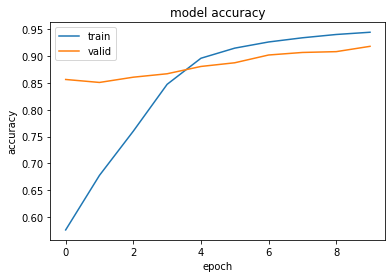

In [72]:
### =========== Your code here ====================

# plt.plot(    )
# plt.plot(    )
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')

plt.plot(cnn_train_history.history['accuracy'])
plt.plot(cnn_train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
### ===============================================

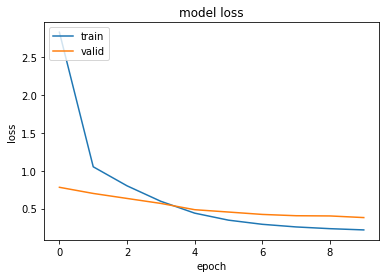

In [73]:
### =========== Your code here ====================


plt.plot(cnn_train_history.history['loss'])
plt.plot(cnn_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

### 5-4. Result

학습된 모델을 바탕으로 test set을 추론합니다.<br>
추론의 결과는 softmax 결과로 나온 확률값을 반환하기 때문에 `argmax`를 통해 클래스를 지정해주어야 합니다.<br> 


In [74]:
cnn_result = cnn_model.predict(X_test)
cnn_result_class = np.argmax(cnn_result, axis=1)

In [75]:
print(cnn_result)

[[7.0986920e-05 2.0219951e-03 1.3216833e-03 ... 3.8660562e-07
  1.6607546e-05 9.9515462e-01]
 [1.1590236e-04 7.0346161e-03 1.3015051e-03 ... 2.8519387e-06
  8.2991364e-06 9.9000412e-01]
 [9.1497335e-05 6.1587142e-03 5.0285906e-03 ... 3.3213171e-06
  1.2738528e-05 9.8430902e-01]
 ...
 [2.8237866e-06 3.2346495e-03 1.1029991e-03 ... 1.8647739e-06
  4.6297000e-06 9.9048179e-01]
 [1.7420854e-06 5.1934418e-04 3.1170418e-04 ... 3.6261719e-07
  1.2790922e-06 9.9719232e-01]
 [6.8427630e-07 1.4412930e-04 1.1287540e-03 ... 3.8212445e-08
  2.6316394e-07 9.9814034e-01]]


In [76]:
print(cnn_result_class)

[13 13 13 ... 13 13 13]


classification report를 출력합니다. <br>
만약 추론 결과값 내에 모든 클래스 (여기서는 0~13 의 14개 클래스)가 포함되어 있다면 class index만 기록된 1-D array를 그대로 사용해도 관게 없습니다. 그러나 우리 데이터와 같이 class imbalance 가 심하여 test set에 모든 클래스가 포함되지 않을 수 있는 경우, label indicator array를 만들어 confusion matix를 계산해야 합니다. <br>
`label_binarize` 함수를 통해 쉽게 변환할 수 있습니다.

In [77]:
cnn_result_binarized = label_binarize(cnn_result_class, classes = list(symbol_idx_dict.values()))
label_test_binarized = label_binarize(label_test, classes = list(symbol_idx_dict.values()))

In [78]:
print(classification_report(label_test_binarized, cnn_result_binarized, target_names=list(idx_symbol_dict.values())))

              precision    recall  f1-score   support

           L       0.99      0.65      0.79      2483
           R       0.97      0.75      0.84      1644
           V       0.61      0.62      0.62      1211
           /       0.97      0.97      0.97      2071
           A       0.00      0.00      0.00      1767
           f       0.00      0.00      0.00         0
           F       0.00      0.00      0.00         3
           j       0.00      0.00      0.00         1
           a       0.00      0.00      0.00         6
           E       0.00      0.00      0.00         0
           J       0.00      0.00      0.00         0
           e       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           N       0.86      1.00      0.92     17745

   micro avg       0.87      0.87      0.87     26931
   macro avg       0.31      0.29      0.30     26931
weighted avg       0.82      0.87      0.83     26931
 samples avg       0.87   

클래스 별 roc curve를 다음과 같이 출력하여 성능을 확인할 수 있습니다.<br>
micro averaging을 통해 전체 클래스의 평균 roc 커브를 plotting 합니다.

In [80]:
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:, i], 
                                          cnn_result[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], thresh['micro'] = roc_curve(label_test_binarized.ravel(), 
                                                                cnn_result.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])        
roc_score = roc_auc['micro']

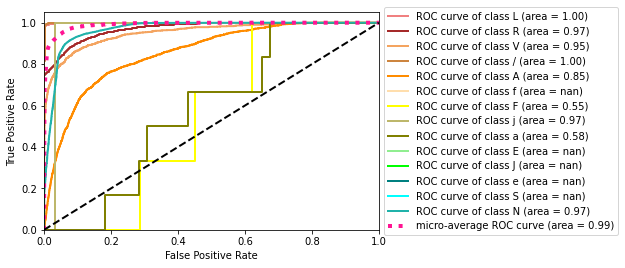

In [81]:
plot_fpr, plot_tpr, plot_thresh, plot_roc_auc = (fpr, tpr, thresh, roc_auc)
lw=2
# Plot all ROC curves
plt.figure()

colors = cycle(['lightcoral', 'brown', 'sandybrown',
                'peru', 'darkorange', 'navajowhite',
                'yellow', 'darkkhaki', 'olive', 
                'lightgreen', 'lime', 'teal',
                'aqua', 'lightseagreen', 'deepskyblue',
                'cornflowerblue', 'navy', 'slateblue', 
               'blueviolet', 'plum', 'pink'])

for i, ((symbol, symidx), color) in enumerate(zip(symbol_idx_dict.items(), colors)):
    plt.plot(plot_fpr[i], plot_tpr[i], color=color, lw=lw,
             label='ROC curve of class {} (area = {:.2f})'.format(str(symbol), plot_roc_auc[i]))
    
plt.plot(plot_fpr["micro"], plot_tpr["micro"],
     label='micro-average ROC curve (area = {0:0.2f})'
           ''.format(plot_roc_auc["micro"]),
     color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()